# Hypothesis Testing

From lecture, we know that hypothesis testing is a critical tool in determing what the value of a parameter could be.

We know that the basis of our testing has two attributes:

**Null Hypothesis: $H_0$**

**Alternative Hypothesis: $H_a$**

The tests we have discussed in lecture are:

* One Population Proportion
* Difference in Population Proportions
* One Population Mean
* Difference in Population Means

In this tutorial, I will introduce some functions that are extremely useful when calculating a t-statistic and p-value for a hypothesis test.

Let's quickly review the following ways to calculate a test statistic for the tests listed above.

The equation is:

$$\frac{Best\ Estimate - Hypothesized\ Estimate}{Standard\ Error\ of\ Estimate}$$ 

We will use the examples from our lectures and use python functions to streamline our tests.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

%matplotlib inline
sns.set_theme(rc={'figure.dpi':150,'figure.figsize':(10,6)})

In [2]:
df = pd.read_csv("nhanes_2015_2016.csv")

In [3]:
df.shape

(5735, 28)

In [4]:
# np.nan represents a missing value

# Smoker
df['SMQ020x'] = df['SMQ020'].replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})

# Gender
df['RIAGENDRx'] = df['RIAGENDR'].replace({1:'Male', 2:'Female'})

# Citizenship status
df['DMDCITZNx'] = df['DMDCITZN'].replace({1:'Yes', 2: "No", 7: np.nan, 9: np.nan})

df.iloc[:,-3:].head()

,SMQ020x,RIAGENDRx,DMDCITZNx
0,Yes,Male,Yes
1,Yes,Male,No
2,Yes,Male,Yes
3,No,Female,Yes
4,No,Female,Yes


### Hypothesis tests for one proportions

The most basic hypothesis test may be the one-sample test for a proportion.  This test is used if we have specified a particular value as the null value for the proportion, and we wish to assess if the data are compatible with the true parameter value being equal to this specified value.  One-sample tests are not used very often in practice, because it is not very common that we have a specific fixed value to use for comparison. 

For illustration, imagine that the rate of lifetime smoking in another country was known to be 40%, and we wished to assess whether the rate of lifetime smoking in the US were different from 40%.  In the following notebook cell, we carry out the (two-sided) one-sample test that the population proportion of smokers is 0.4, and obtain a p-value of 0.43.  This indicates that the NHANES data are compatible with the proportion of (ever) smokers in the US being 40%. 

One sample Z-test for proportion formula:
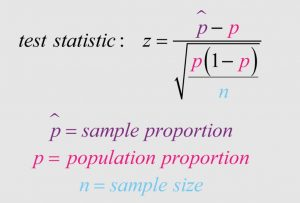
- p_hat = Sample proportion (hypothesized)

- P0 = Population proportion (theoritical)

- SE = Standard error, SE = SQRT[P0(1-P0)/n]

- n = Sample size

In [5]:
# Assuming p = 0.4

x = df['SMQ020x'].dropna() == "Yes"

p_hat = x.mean()

se = np.sqrt(0.4 * (1 - 0.4) / len(x))

test_stat = (p_hat - 0.4) / se

pvalue = 2 * stats.norm.cdf(-np.abs(test_stat))

# Print results
print("One Proportion Test")
print("Test Statistic:", test_stat)
print("P-value:", pvalue)


One Proportion Test
Test Statistic: 0.7823563854332805
P-value: 0.4340051581348052


The following cell carries out the same test as performed above using the Statsmodels library.  The results in the first (default) case below are slightly different from the results obtained above because Statsmodels by default uses the sample proportion instead of the null proportion when computing the standard error.  This distinction is rarely consequential, but we can specify that the null proportion should be used to calculate the standard error, and the results agree exactly with what we calculated above.  The first two lines below carry out tests using the normal approximation to the sampling distribution of the test statistic, and the third line below carries uses the exact binomial sampling distribution.  We can see here that the p-values are nearly identical in all three cases. This is expected when the sample size is large, and the proportion is not close to either 0 or 1.

In [6]:
# Other way using sm.stats.proportions_ztest

count = len(df[df['SMQ020x'] == "Yes"])
nobs = len(df['SMQ020x'].dropna())
z_stat,p_value = sm.stats.proportions_ztest(count, nobs, value=0.4)

# Print results
print("One Proportion Test")
print("Z-statistic:", z_stat)
print("P-value:", p_value)

One Proportion Test
Z-statistic: 0.7807518954896244
P-value: 0.43494843171868214


In [7]:
# Prints the p-value
print(sm.stats.binom_test(x.sum(), len(x), 0.4)) # Exact binomial p-value

0.4340360854410036


> The one-sample test for a proportion comparing the rate of lifetime smoking in the US to a specified value of 40% yielded.
>
> The test was conducted using a two-sided alternative hypothesis. The obtained p-value of 0.43 suggests that the NHANES data are compatible with the proportion of lifetime smokers in the US being 40%. This means that there is no significant evidence to suggest a difference between the observed proportion in the data and the specified value of 40%. Therefore, we fail to reject the null hypothesis, and it can be concluded that the rate of lifetime smoking in the US is not significantly different from 40% based on the available data.

### Hypothesis tests for two proportions

Comparative tests tend to be used much more frequently than tests comparing one population to a fixed value.  A two-sample test of proportions is used to assess whether the proportion of individuals with some trait differs between two sub-populations.  For example, we can compare the smoking rates between females and males. Since smoking rates vary strongly with age, we do this in the subpopulation of people between 20 and 25 years of age.  In the cell below, we carry out this test without using any libraries, implementing all the test procedures covered elsewhere in the course using Python code.  We find that the smoking rate for men is around 10 percentage points greater than the smoking rate for females, and this difference is statistically significant (the p-value is around 0.01).
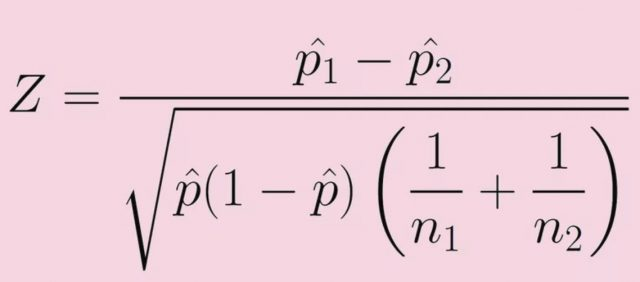
- p1_hat is the proportion of the 1st sample

- p2_hat is the proportion of the 2nd sample

- n1 is number of data samples in the 1st sample

- n2 is number of data samples in the 2nd sample

- p_hat is mean of both the samples; 

In [8]:
# Drop missing values
dx = df[["SMQ020x", "RIDAGEYR", "RIAGENDRx"]].dropna()

# Restrict to people between 20 and 25 years old
dx = dx[(dx['RIDAGEYR'] >= 20) & (dx['RIDAGEYR'] <= 25)]

counts = dx[['RIAGENDRx', 'SMQ020x']].value_counts() #the 2nd bracket [] meaning list
counts 

RIAGENDRx  SMQ020x
Female     No         207
Male       No         166
           Yes         86
Female     Yes         65
dtype: int64

In [9]:
# Summarize the data by caclculating the proportion of yes responses and the sample size

aggregator = lambda z: np.mean(z=='Yes'), 'size'

p_hat = dx.groupby('RIAGENDRx')['SMQ020x'].agg(aggregator)
p_hat.columns = ["Smoke", "N"]
p_hat

,Smoke,N
RIAGENDRx,,
Female,0.238971,272
Male,0.341270,252


In [10]:
# Calculate the pooled rate of 'Yes' responses
p_hat_combined = (dx['SMQ020x'] == 'Yes').mean()

# Calculate the standard error
se = np.sqrt(p_hat_combined * (1 - p_hat_combined) * (1 / p_hat['N']['Female'] + 1 / p_hat['N']['Male']))

# Calculate the test statistic
test_stat = (p_hat['Smoke']['Female'] - p_hat['Smoke']['Male']) / se

# Calculate the p-value
p_value = 2 * stats.norm.cdf(-np.abs(test_stat))

# Print results
print("Two Proportion Test")
print("Test Statistic:", test_stat)
print("P-value:", p_value)

Two Proportion Test
Test Statistic: -2.5833303066279414
P-value: 0.009785159057508375


Essentially the same test as above can be conducted by converting the "Yes"/"No" responses to numbers (Yes=1, No=0) and conducting a two-sample t-test, as below:

In [11]:
# Unstack the counts 
unstacked_counts = counts.unstack()

# Add a column for the total count of females and males
unstacked_counts['Total'] = unstacked_counts.sum(axis = 1)

unstacked_counts

SMQ020x,No,Yes,Total
RIAGENDRx,,,
Female,207,65,272
Male,166,86,252


In [12]:
# Difference of Proportion using Z-test

z_stat, p_value = sm.stats.proportions_ztest([unstacked_counts['Yes']['Female'], unstacked_counts['Yes']['Male']],
                                             [unstacked_counts['Total']['Female'], unstacked_counts['Total']['Male']])

# Print results
print("Difference of Proportions Test")
print("Z-statistic:", z_stat)
print("P-value:", p_value)

Difference of Proportions Test
Z-statistic: -2.5833303066279414
P-value: 0.009785159057508375


In [13]:
# Difference of Proportion using T-test
dx_females = dx.loc[dx['RIAGENDRx']=="Female", "SMQ020x"].replace({"Yes": 1, "No": 0})
dx_females

17      0
38      0
46      0
69      1
102     1
       ..
5622    0
5649    0
5678    1
5707    0
5734    0
Name: SMQ020x, Length: 272, dtype: int64

In [14]:
dx_males = dx.loc[dx['RIAGENDRx']=="Male", "SMQ020x"].replace({"Yes": 1, "No": 0})
dx_males

6       1
26      1
40      1
48      0
96      0
       ..
5602    0
5667    1
5688    0
5701    0
5729    0
Name: SMQ020x, Length: 252, dtype: int64

In [71]:
z_stat, p_value,dof  =sm.stats.ttest_ind(dx_females, dx_males)
# Print results
print("Difference of Proportions Test")
print("T-statistic:", z_stat)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)

Difference of Proportions Test
T-statistic: -2.5949731446269344
P-value: 0.00972590232121254
Degrees of Freedom: 522.0


> The two-sample test of proportions comparing the smoking rates between females and males in the subpopulation of people between 20 and 25 years of age. 
> 
> Both the T-statistic and Z-statistic indicate a significant difference in smoking rates between females and males. The negative values of the test statistics suggest that the smoking rate for males is higher than that for females. The small p-values (around 0.01) indicate strong evidence to reject the null hypothesis that the proportions are equal. 
>
> This suggests that there is a statistically significant difference in the smoking rates between females and males, with males having a higher smoking rate by approximately 10 percentage points.

### Hypothesis tests comparing means

Tests of means are similar in many ways to tests of proportions.  Just as with proportions, for comparing means there are one and two-sample tests, z-tests and t-tests, and one-sided and two-sided tests.  As with tests of proportions, one-sample tests of means are not very common, but we illustrate a one sample test in the cell below.  We compare systolic blood pressure to the fixed value 120 (which is the lower threshold for "pre-hypertension"), and find that the mean is significantly different from 120 (the point estimate of the mean is 126).
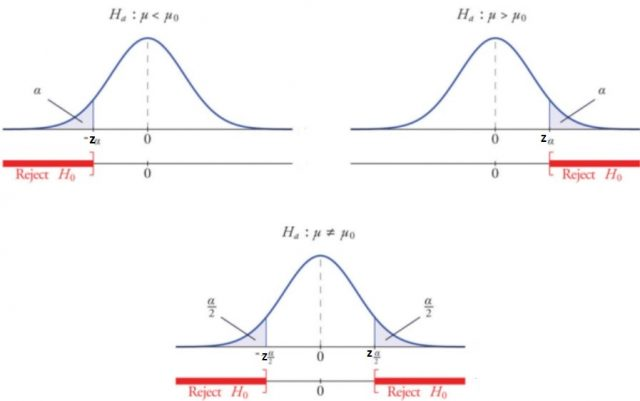

### Comparing one mean

In [20]:
dx = df[["BPXSY1", "RIDAGEYR", "RIAGENDRx"]].dropna()
dx

,BPXSY1,RIDAGEYR,RIAGENDRx
0,128.0,62,Male
1,146.0,53,Male
2,138.0,78,Male
3,132.0,56,Female
4,100.0,42,Female
...,...,...,...
5730,112.0,76,Female
5731,118.0,26,Male
5732,154.0,80,Female
5733,104.0,35,Male


In [29]:
dx = dx[(dx['RIDAGEYR'] >=40 ) & (dx['RIDAGEYR'] <= 50)]
dx

,BPXSY1,RIDAGEYR,RIAGENDRx
4,100.0,42,Female
10,144.0,46,Male
11,116.0,45,Male
20,110.0,49,Male
42,128.0,42,Male
...,...,...,...
5690,138.0,48,Male
5693,96.0,41,Male
5713,116.0,43,Male
5718,128.0,45,Male


In [30]:
dx['BPXSY1'].mean()

123.19399785637728

In [31]:
sm.stats.ztest(dx['BPXSY1'], value = 120)

(6.145624644550912, 7.964943689436156e-10)

> The test indicates that the mean systolic blood pressure, with a point estimate of 126, is significantly different from 120. The large Z-statistic and the very small p-value provide strong evidence to reject the null hypothesis that the mean systolic blood pressure is equal to 120. 
>
> This suggests that, on average, the systolic blood pressure in the sample is higher than the threshold for "pre-hypertension" defined by 120.

### Comparing two means
In the cell below, we carry out a formal test of the null hypothesis that the mean blood pressure for women between the ages of 50 and 60 is equal to the mean blood pressure of men between the ages of 50 and 60. The results indicate that while the mean systolic blood pressure for men is slightly greater than that for women (129 mm/Hg versus 128 mm/Hg), this difference is not statistically significant.

There are a number of different variants on the two-sample t-test. Two often-encountered variants are the t-test carried out using the t-distribution, and the t-test carried out using the normal approximation to the reference distribution of the test statistic, often called a z-test. Below we display results from both these testing approaches. When the sample size is large, the difference between the t-test and z-test is very small.
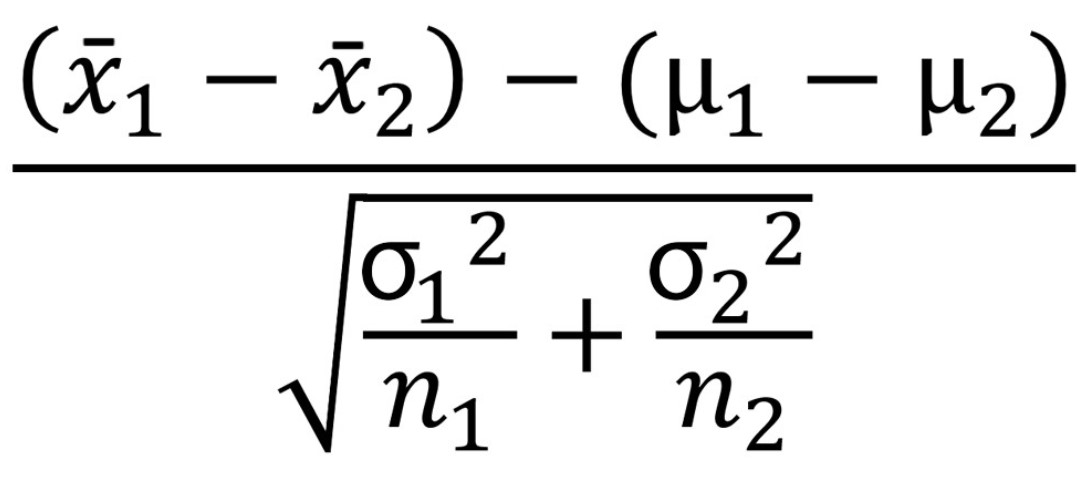

In [48]:
dx = df[["BPXSY1", "RIDAGEYR", "RIAGENDRx"]].dropna()
dx = dx[(dx['RIDAGEYR'] >= 50) & (dx['RIDAGEYR'] <= 60)]

bpx_female = dx[dx['RIAGENDRx'] == 'Female']['BPXSY1']
bpx_male = dx[dx['RIAGENDRx'] == 'Male']['BPXSY1']

z_stat, p_value = sm.stats.ztest(bpx_female, bpx_male)

print("Z-statistic:", z_stat)
print("P-value:", p_value)

Z-statistic: -1.105435895556249
P-value: 0.2689707570859362


In [49]:
z_stat, p_value, dof = sm.stats.ttest_ind(bpx_female, bpx_male)
print("T-statistic:", z_stat)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)

T-statistic: -1.105435895556249
P-value: 0.26925004137768577
Degrees of Freedom: 952.0


> The analysis indicates that the mean systolic blood pressure for men (129 mm/Hg) is slightly greater than that for women (128 mm/Hg) in the age group of 50 to 60. However, the difference in means is not statistically significant. Both the Z-test and the T-test yield similar results, suggesting no strong evidence to reject the null hypothesis that the mean blood pressure for women is equal to the mean blood pressure for men in this age group.
>
> In conclusion, based on the available data, there is no significant difference in mean blood pressure between women and men in the age group of 50 to 60.

### Heteroscedasticity
Another important aspect of two-sample mean testing is "heteroscedasticity", meaning that the variances within the two groups being compared may be different. While the goal of the test is to compare the means, the variances play an important role in calibrating the statistics (deciding how big the mean difference needs to be to be declared statistically significant). In the NHANES data, we see that there are moderate differences between the amount of variation in BMI for females and for males, looking within 10-year age bands. In every age band, females having greater variation than males.

In [52]:
dx = df[["BMXBMI", "RIDAGEYR", "RIAGENDRx"]].dropna()

age = [18, 30, 40, 50, 60, 70, 80]

dx['agegroup'] = pd.cut(dx['RIDAGEYR'], age)

dx.groupby(['agegroup','RIAGENDRx'])['BMXBMI'].agg(np.std).unstack()

RIAGENDRx,Female,Male
agegroup,,
"(18, 30]",7.745893,6.649440
"(30, 40]",8.315608,6.622412
"(40, 50]",8.076195,6.407076
"(50, 60]",7.575848,5.914373
"(60, 70]",7.604514,5.933307
"(70, 80]",6.284968,4.974855


The standard error of the mean difference (e.g. mean female blood pressure minus mean male blood pressure) can be estimated in at least two different ways. In the statsmodels library, these approaches are referred to as the "pooled" and the "unequal" approach to estimating the variance. If the variances are equal (i.e. there is no heteroscedasticity), then there should be little difference between the two approaches. Even in the presence of moderate heteroscedasticity, as we have here, we can see that the results for the two methods are quite similar. Below we have a loop that considers each 10-year age band and assesses the evidence for a difference in mean BMI for women and for men. The results printed in each row of output are the test-statistic and p-value.

In [59]:
for age_group, group_data in dx.groupby("agegroup"):
    bmi_female = group_data.loc[group_data['RIAGENDRx'] == "Female", "BMXBMI"].dropna()
    bmi_female_stats = sm.stats.DescrStatsW(bmi_female)
    
    bmi_male = group_data.loc[group_data['RIAGENDRx'] == "Male", "BMXBMI"].dropna()
    bmi_male_stats = sm.stats.DescrStatsW(bmi_male)
    
    print(age_group)
    print("Pooled variance:")
    print("- Test statistic:", sm.stats.CompareMeans(bmi_female_stats, bmi_male_stats).ztest_ind(usevar='pooled')[0])
    print("- p-value:", sm.stats.CompareMeans(bmi_female_stats, bmi_male_stats).ztest_ind(usevar='pooled')[1])
    print()
    print("Unequal variance:")
    print("- Test statistic:", sm.stats.CompareMeans(bmi_female_stats, bmi_male_stats).ztest_ind(usevar='unequal')[0])
    print("- p-value:", sm.stats.CompareMeans(bmi_female_stats, bmi_male_stats).ztest_ind(usevar='unequal')[1])
    print('\n--------\n')


(18, 30]
Pooled variance:
- Test statistic: 1.7026932933643306
- p-value: 0.08862548061449803

Unequal variance:
- Test statistic: 1.7174610823927183
- p-value: 0.08589495934713169

--------

(30, 40]
Pooled variance:
- Test statistic: 1.4378280405644919
- p-value: 0.15048285114648174

Unequal variance:
- Test statistic: 1.4437869620833497
- p-value: 0.1487989105789246

--------

(40, 50]
Pooled variance:
- Test statistic: 2.8933761158070186
- p-value: 0.003811246059501354

Unequal variance:
- Test statistic: 2.9678691663536725
- p-value: 0.0029987194174035366

--------

(50, 60]
Pooled variance:
- Test statistic: 3.362108779981383
- p-value: 0.0007734964571391287

Unequal variance:
- Test statistic: 3.3754943901739387
- p-value: 0.0007368319423226156

--------

(60, 70]
Pooled variance:
- Test statistic: 3.617240144243268
- p-value: 0.00029776102103194453

Unequal variance:
- Test statistic: 3.628483094544553
- p-value: 0.00028509141471492935

--------

(70, 80]
Pooled variance:
- Tes

> The test statistics and p-values indicate the evidence for a difference in mean BMI between women and men within each age group. A lower p-value suggests stronger evidence against the null hypothesis of no difference. The results show that in most age groups, there is evidence of a statistically significant difference in mean BMI between women and men, regardless of whether the pooled or unequal variance approach is used.

### Paired tests
A common situation in applied research is to measure the same quantity multiple times on each unit of analysis. For example, in NHANES, systolic blood pressure is measured at least two times (sometimes there is a third measurement) on each subject. Although the measurements are repeated, there is no guarantee that the mean is the same each time, i.e. the mean blood pressure may be slightly lower on the second measurement compared to the first, since people are a bit more nervous the first time they are measured. A paired test is a modified form of mean test that can be used when we are comparing two repeated measurements on the same unit.

A paired t-test for means is equivalent to taking the difference between the first and second measurement, and using a one-sample test to compare the mean of these differences to zero. Below we see that in the entire NHANES sample, the first measurement of systolic blood pressure is on average 0.67 mm/Hg greater than the second measurement. While this difference is not large, it is strongly statistically significant. That is, there is strong evidence that the mean values for the first and second blood pressure measurement differ.

In [60]:
dx = df[["BPXSY1", "BPXSY2"]].dropna()
dx

,BPXSY1,BPXSY2
0,128.0,124.0
1,146.0,140.0
2,138.0,132.0
3,132.0,134.0
4,100.0,114.0
...,...,...
5730,112.0,112.0
5731,118.0,116.0
5732,154.0,146.0
5733,104.0,106.0


In [67]:
mean_diff = (dx['BPXSY1'] - dx['BPXSY2']).mean()
mean_diff

0.6749860309182343

In [70]:
z_stat, p_value = sm.stats.ztest(dx['BPXSY1'] - dx['BPXSY2'])

print("Paired tests")
print("Z-statistic:", z_stat)
print("P-value:", p_value)

Paired tests
Z-statistic: 9.800634425497911
P-value: 1.1188070930963587e-22


> The paired t-test you conducted on the NHANES data indicates that there is a statistically significant difference between the mean values of the first and second systolic blood pressure measurements. The test statistic is calculated as 9.800634425497911, and the corresponding p-value is approximately 1.1188070930963587e-22.
> 
> Based on these results, we can conclude that there is strong evidence to suggest that the mean values of the first and second blood pressure measurements differ. In other words, the average systolic blood pressure tends to be slightly higher on the first measurement compared to the second measurement. This finding is consistent with the notion that people may be more nervous during the first measurement, leading to slightly elevated blood pressure readings.
> 
> It's important to note that the observed difference, although statistically significant, is not considered large in magnitude. However, the statistical significance indicates that the observed difference is unlikely to be due to random chance alone and is likely a genuine difference between the two measurements.

In [72]:
def ztest_ind(X1, X2, mudiff, std_dev_1, std_dev_2, n1, n2):
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    pooled_SE = sqrt(std_dev_1**2/n1 + std_dev_2**2/n2)
    z = ((X1 - X2) - mudiff)/pooled_SE
    pval = 2*(norm.sf(abs(z)))
    return round(z, 3), round(pval, 4)

In [74]:
z_statistics, p_value = ztest_ind(750, 780, 0, 20, 25, 300, 300)
print("Z-statistics: ", z_statistics)
print("P-value: ", p_value)

Z-statistics:  -16.23
P-value:  0.0


To probe this effect further, we can divide the population into 10 year wide age bands and also stratify by gender, then carry out the paired t-test within each of the resulting 12 strata. We see that the second systolic blood pressure measurement is always lower on average than the first. The difference is larger for older people and for males. The difference is statistically significant for females over 30, and for males over 60.

Conducting many hypothesis tests and "cherry picking" the interesting results is usually a bad practice. Here we are doing such "multiple testing" for illustration, and acknowledge that the strongest differences may be over-stated. Nevertheless, there is a clear and consistent trend with age -- older people tend to have greater differences between their first and second blood pressure measurements than younger people. There is also a difference between the genders, with older men having a stronger difference between the first and second blood pressure measurements than older women. The gender difference for younger peple is less clear.

In [77]:
dx = df[["RIAGENDRx", "BPXSY1", "BPXSY2", "RIDAGEYR"]].dropna()
dx["agegroup"] = pd.cut(dx.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])

for k, g in dx.groupby(["RIAGENDRx", "agegroup"]):
    db = g.BPXSY1 - g.BPXSY2
    mean_difference = db.mean()
    sample_size = db.size
    test_statistic, p_value = sm.stats.ztest(db.values, value=0)
    
    # Extract stratum information
    gender, age_group = k
    
    # Print results for each stratum
    print(f"Stratum: Gender={gender}, Age Group={age_group}")
    print(f"Mean Difference: {mean_difference:.2f}")
    print(f"Sample Size: {sample_size}")
    print(f"Test Statistic: {test_statistic:.2f}")
    print(f"P-value: {p_value:.4f}")
    print()

Stratum: Gender=Female, Age Group=(18, 30]
Mean Difference: 0.14
Sample Size: 569
Test Statistic: 0.76
P-value: 0.4465

Stratum: Gender=Female, Age Group=(30, 40]
Mean Difference: 0.67
Sample Size: 426
Test Statistic: 3.31
P-value: 0.0009

Stratum: Gender=Female, Age Group=(40, 50]
Mean Difference: 0.60
Sample Size: 469
Test Statistic: 2.60
P-value: 0.0092

Stratum: Gender=Female, Age Group=(50, 60]
Mean Difference: 0.77
Sample Size: 445
Test Statistic: 3.10
P-value: 0.0019

Stratum: Gender=Female, Age Group=(60, 70]
Mean Difference: 0.88
Sample Size: 396
Test Statistic: 3.10
P-value: 0.0019

Stratum: Gender=Female, Age Group=(70, 80]
Mean Difference: 1.45
Sample Size: 390
Test Statistic: 5.14
P-value: 0.0000

Stratum: Gender=Male, Age Group=(18, 30]
Mean Difference: 0.00
Sample Size: 512
Test Statistic: 0.02
P-value: 0.9844

Stratum: Gender=Male, Age Group=(30, 40]
Mean Difference: 0.46
Sample Size: 432
Test Statistic: 1.95
P-value: 0.0518

Stratum: Gender=Male, Age Group=(40, 50]
Mea

### Power and sample size for hypothesis tests
Like nearly any analysis with data, hypothesis tests will yield more sensitive and confident results when there are larger amounts of data. Here we will study the relationship between the sample size (amount of data), and the behavior of a hypothesis test. For illustration, we will use the paired t-test for assessing whether the first and second systolic blood pressure measurement have different means, restricting to people between 50 and 60 years of age.

The simulation below randomly subsamples sets of 100, 200, 400, and 800 people from the 50-60 year old subset of NHANES, and conducts a paired z-test on each subsample. This process is repeated 500 times for each sample size. We report the fraction of these 500 trials where the p-value was smaller than 0.05. A higher fraction of trials where p<0.05 implies that it is easier to detect a difference between the first and second blood pressure measurements. We see that this proportion (called "statistical power") is only around 0.2 when the sample size is 100, and grows to essentially 100% when the sample size is 800. Note that all of these subsamples are drawn from the same parent population, so there is no change from subsample to subsample in terms of whether the means are truly different. The only thing that changes is our evidence that the difference is real. When the sample size is small, we rarely amass such evidence.

In [82]:
# Select the age group of interest (50-60 years)
age_group = dx[(dx.RIDAGEYR >= 50) & (dx.RIDAGEYR <= 60)]

# Initialize a list to store the p-values for each sample size
all_p_values = []

# Iterate over different sample sizes: 100, 200, 400, 800
for sample_size in [100, 200, 400, 800]:
    p_values = []  # Initialize a list to store the p-values for each trial
    
    # Repeat the process 500 times
    for _ in range(500):
        # Randomly subsample the data
        subsample = age_group.sample(sample_size)  
        
        # Calculate the difference between first and second blood pressure measurements
        difference = subsample.BPXSY1 - subsample.BPXSY2
        
        # Perform the paired z-test
        _, p_value = sm.stats.ztest(difference.values, value=0)  
        
        # Store the p-value
        p_values.append(p_value)  
        
    p_values = np.asarray(p_values)  # Convert the list of p-values to a numpy array
    all_p_values.append(p_values)  # Store the p-values for this sample size
    power = (p_values <= 0.05).mean()  # Calculate the proportion of trials with p < 0.05 (statistical power)
    print(f"Sample Size: {sample_size}, Statistical Power: {power}")



Sample Size: 100, Statistical Power: 0.218
Sample Size: 200, Statistical Power: 0.35
Sample Size: 400, Statistical Power: 0.678
Sample Size: 800, Statistical Power: 1.0


In the simulation code above, we saved all the p-values to the array named all_p_values so we can consider them further here. The histogram below shows the distribution of p-values for 500 subsamples of data of size 100. We see that there are more smaller p-values than larger ones, but not to a dramatic degree. Some of the p-values are almost 1, indicating that the subsample mean differences were almost zero in those cases.

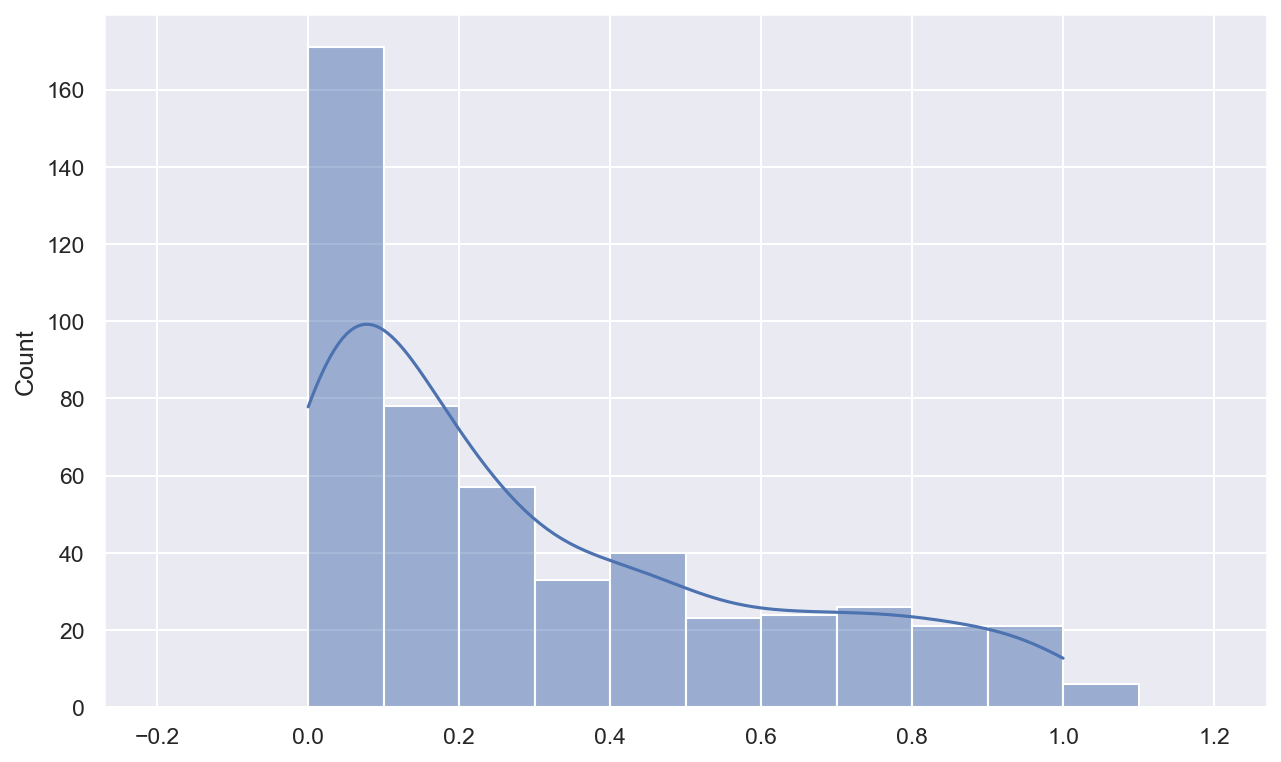

In [88]:
sns.histplot(all_p_values[0], kde=True, binrange=(-0.2, 1.2));

Next we inspect the distribution of p-values for subsamples of size 400. We see that the p-values are much more concentrated close to zero compared to when we had only 100 data points. If we obtain a sample of size 400 from this population, we have around a 70% chance of obtaining a p-value smaller than 0.05, and are very unlikely to obtain a p-value greater than 0.4.

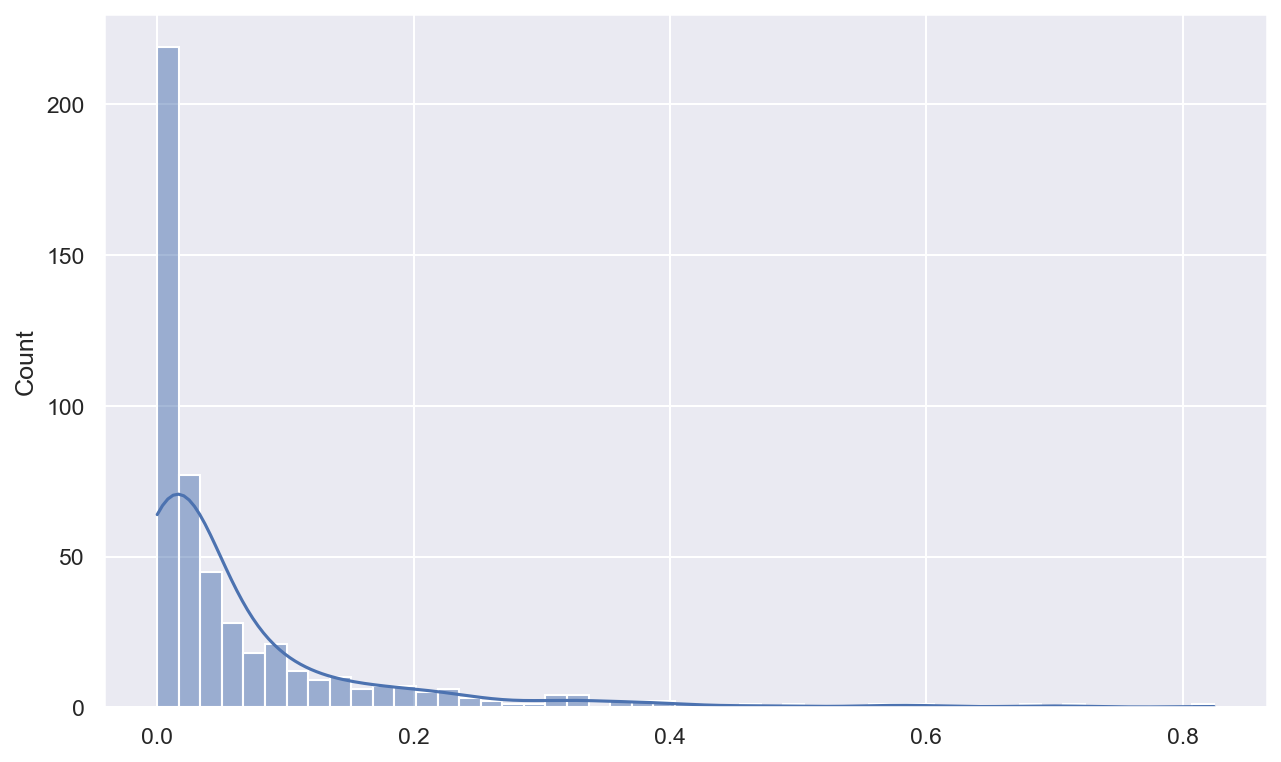

In [90]:
sns.histplot(all_p_values[2], kde=True);

> The histogram of p-values for subsamples of size 100 shows a distribution where some p-values are small (indicating evidence of a difference) while others are close to 1 (indicating little to no evidence of a difference). This suggests that with a smaller sample size, the statistical power of the test is limited, and it becomes more challenging to detect a true difference.
> 
> In contrast, the histogram of p-values for subsamples of size 400 shows a more concentrated distribution closer to zero. This indicates that with a larger sample size, the test has higher statistical power, making it easier to detect a true difference. The majority of p-values in this case are smaller than 0.05, suggesting a higher likelihood of correctly identifying a difference.
> 
> Overall, these findings highlight the importance of sample size in hypothesis testing. Larger sample sizes generally yield more sensitive and confident results, increasing the ability to detect true differences and reducing the likelihood of false conclusions.